In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
import pickle

sns.set_style("whitegrid")

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [7]:
train_file = open('merge_data_group.csv', encoding='utf-8')
train = pd.read_csv(train_file)

airport_city_file = open('训练集\\机场城市对应表.csv', encoding='gbk')
airport_city = pd.read_csv(airport_city_file)

airport_city = airport_city.dropna()
airport_city_dict = {}
airport = airport_city['机场编码'].values
city = airport_city['城市名称'].values
for i in range(airport_city.shape[0]):
    airport_city_dict[airport[i]] = city[i]

In [8]:
train_row, train_col = train.shape
 
train['机场'] = [it[2:5] for it in train['机场_时间_航班编号']]
train['航班编号'] = [it[32:-2] for it in train['机场_时间_航班编号']]
train['平均气温'] = (train['最低气温'] + train['最高气温']) / 2

train_type = np.array(['航班无延误或延误三小时以下' for i in range(len(train))])
train_type[ train['y'].values == 1 ] = '航班延误三小时以上'
train['type'] = train_type

In [9]:
def get_company(str_one):
	num_bool = (np.array(list(str_one)) >= '0') & (np.array(list(str_one)) <= '9')
	argmax_bool = np.argmax(num_bool)
	if argmax_bool > 0:
		str_list = str_one[:argmax_bool]
		return ''.join(str_list)
	else:
		return str_one[:2]

train['航空公司'] = [get_company(it) for it in train['航班编号']]

noon_down = ['00', '06', '11', '13', '18']
noon_up = ['06', '11', '13', '18', '24']
noon_type = ['凌晨', '早上', '中午', '下午', '晚上']

In [10]:
def get_noon(str_one):
	for i in range(len(noon_up)):
		if str_one >= noon_down[i] and str_one < noon_up[i]:
			return noon_type[i]
	if str_one == '24':
		return '凌晨'
	raise ValueError

In [11]:
train['时间段'] = [get_noon(it[20:22]) for it in train['机场_时间_航班编号']]
train['时刻'] = [it[20:22] for it in train['机场_时间_航班编号']]

In [12]:
from scipy.stats import ranksums

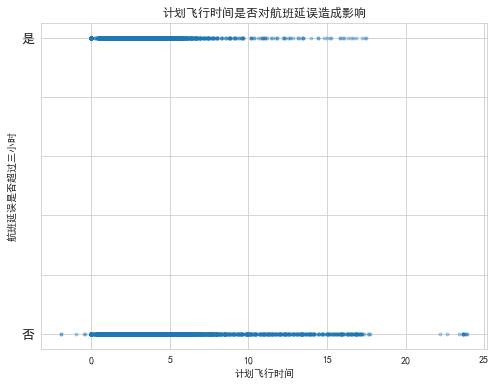

In [15]:
fig, ax = plt.subplots(figsize=(8, 6)) 
plt.plot(train['计划飞行时间'], train['y'],'.', alpha = 0.3)
plt.xlabel('计划飞行时间' )
plt.ylabel('航班延误是否超过三小时' )
ax.set_yticklabels(['', '否','','','','', '是'], fontsize = 13 )
plt.title('计划飞行时间是否对航班延误造成影响' )
plt.show()
fig.savefig('计划飞行时间是否对航班延误造成影响.png')

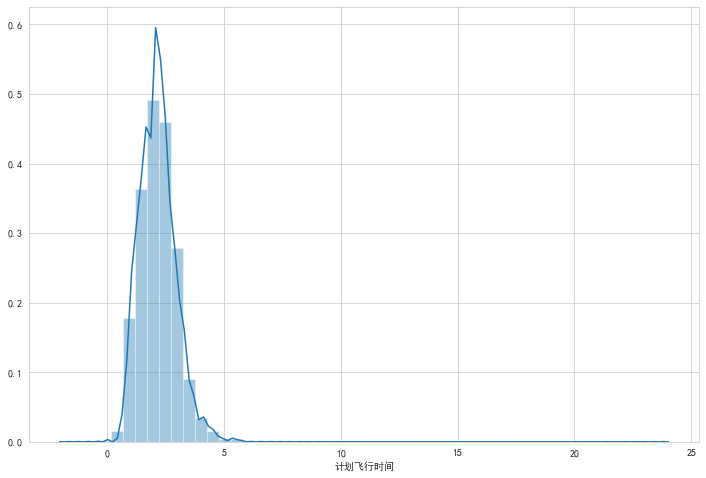

In [23]:
fig, ax = plt.subplots(figsize = (12, 8)) 
sns.distplot(train['计划飞行时间'])
plt.show()
fig.savefig('计划飞行时间的分布.pdf')

RanksumsResult(statistic=59.978329587269464, pvalue=0.0)


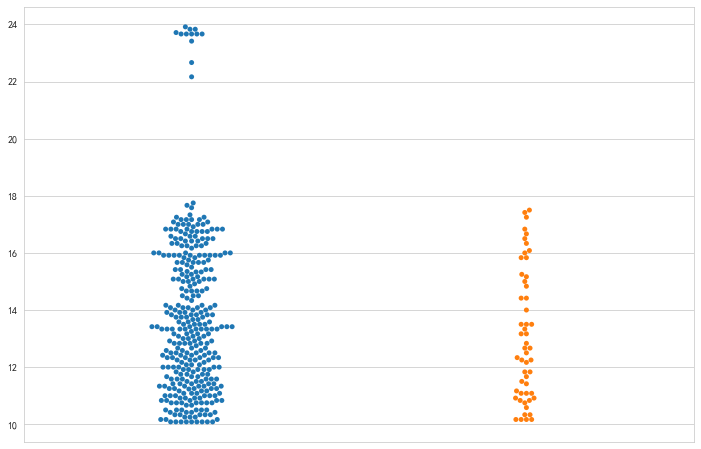

In [25]:
plan_time_true = train['计划飞行时间'][train['y'] == True]
plan_time_false = train['计划飞行时间'][train['y'] == False]

print(ranksums(plan_time_true, plan_time_false))

train_large_time = train.loc[train['计划飞行时间'] > 10,:]
fig, ax = plt.subplots(figsize = (12, 8)) 
sns.swarmplot(train_large_time['type'], train_large_time['计划飞行时间'], order = 
	['航班无延误或延误三小时以下', '航班延误三小时以上'])
plt.xlabel('')
plt.ylabel('')
ax.set_xticklabels([''])
plt.show()
fig.savefig('计划飞行时间是否对航班延误造成影响（scatter）.png')

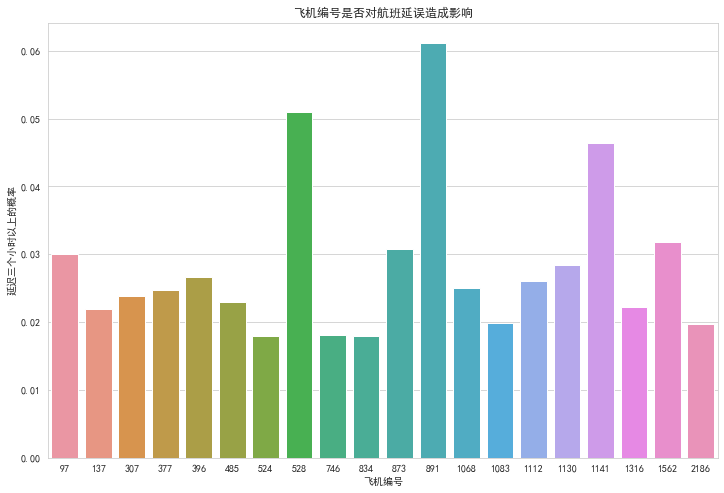

In [26]:
Plane_counts = train['飞机编号'].value_counts()
Plane_counts.index = [int(item) for item in Plane_counts.index]
commonPlane = Plane_counts.iloc[:20].index
train_group = train.groupby('飞机编号')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.barplot([int(it) for it in commonPlane], train_mean_y.loc[commonPlane].values[:,0])
plt.xlabel('飞机编号')
plt.ylabel('延迟三个小时以上的概率')
plt.title('飞机编号是否对航班延误造成影响')
plt.show()
fig.savefig('飞机编号是否对航班延误造成影响.pdf')

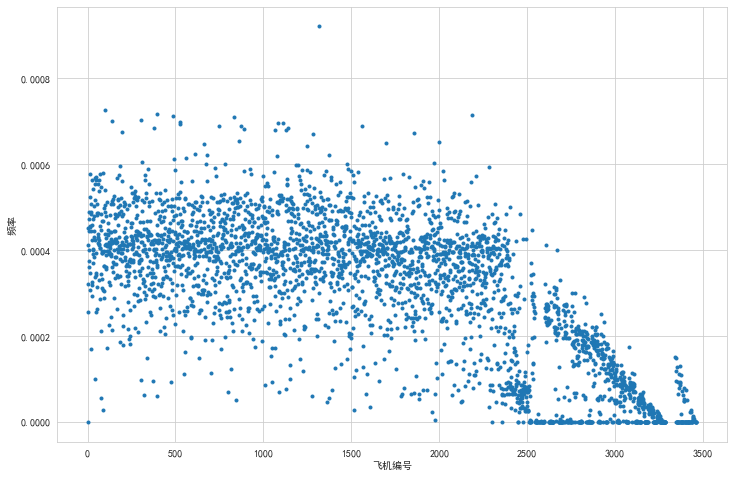

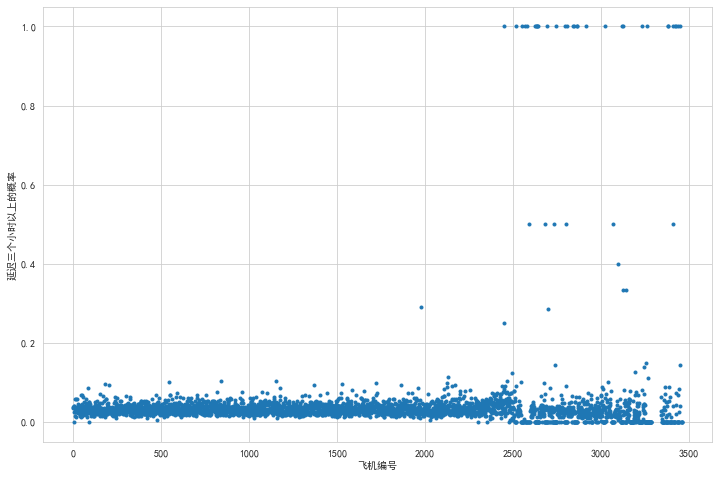

In [27]:
train_mean_y.index = [int(item) for item in train_mean_y.index]

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(Plane_counts / sum(Plane_counts), '.')
plt.xlabel('飞机编号')
plt.ylabel('频率')
plt.show()
fig.savefig('不同飞机编号的频率比较.pdf')

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train_mean_y, '.')
plt.xlabel('飞机编号')
plt.ylabel('延迟三个小时以上的概率')
plt.show()

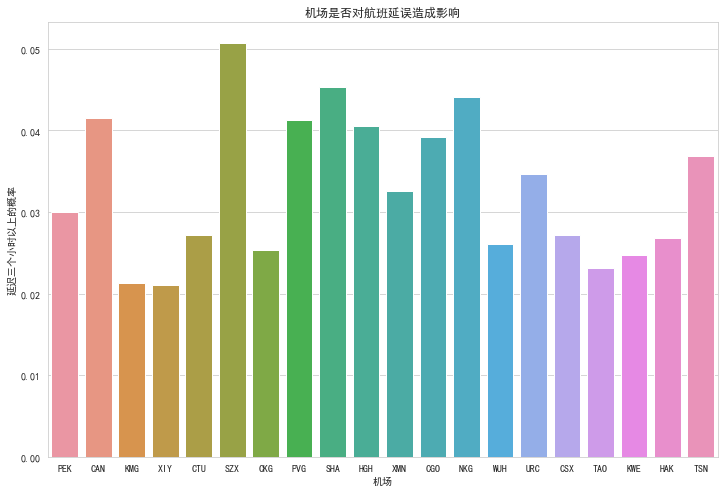

In [38]:
Airport_counts = train['机场'].value_counts()
Airport_counts = Airport_counts / sum(Airport_counts)
commonAirport = Airport_counts.iloc[:20].index
train_group = train.groupby('机场')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.barplot(commonAirport, train_mean_y.loc[commonAirport].values[:,0])
plt.xlabel('机场')
plt.ylabel('延迟三个小时以上的概率')
plt.title('机场是否对航班延误造成影响')
plt.show()
fig.savefig('机场是否对航班延误造成影响.pdf')

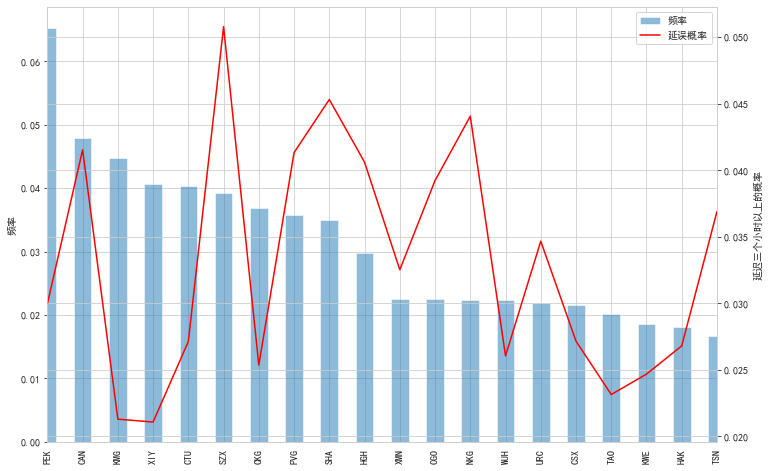

In [39]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
Airport_counts.loc[commonAirport].plot(kind='bar', ax=ax1, alpha=0.5)
train_mean_y.loc[commonAirport].plot(ax=ax2, color='r')
ax1.set_ylabel('频率')
ax2.set_ylabel('延迟三个小时以上的概率')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
labels1 = ['频率']
labels2 = ['延误概率']
plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
plt.show()
fig.savefig('机场是否对航班延误造成影响（2）.pdf')

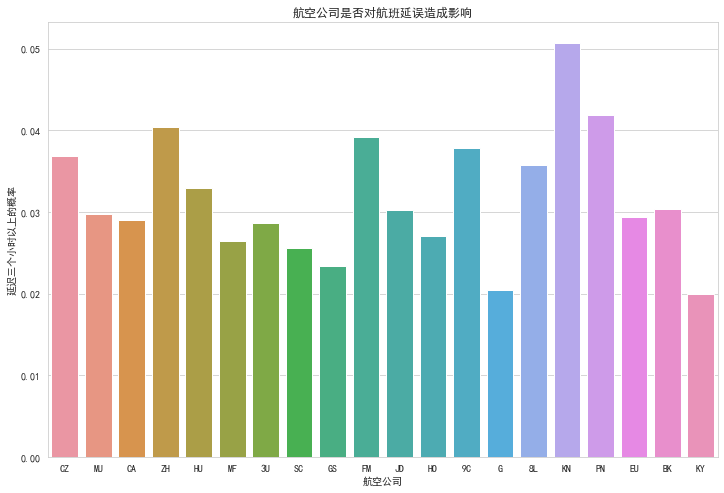

In [42]:
Company_counts = train['航空公司'].value_counts()
Company_counts = Company_counts / Company_counts.sum()
commonCompany = Company_counts.iloc[:20].index
train_group = train.groupby('航空公司')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (12, 8)) 
sns.barplot(commonCompany, train_mean_y.loc[commonCompany].values[:,0])
plt.xlabel('航空公司')
plt.ylabel('延迟三个小时以上的概率')
plt.title('航空公司是否对航班延误造成影响')
plt.show()
fig.savefig('航空公司是否对航班延误造成影响.pdf')

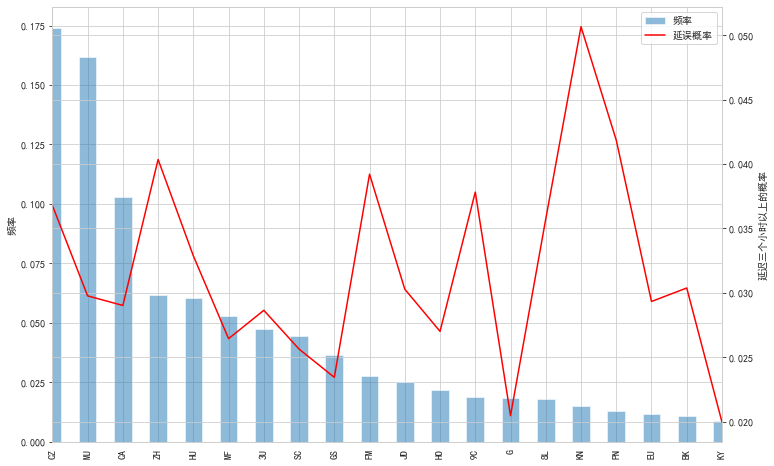

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
Company_counts.loc[commonCompany].plot(kind='bar', ax=ax1, alpha=0.5)
train_mean_y.loc[commonCompany].plot(ax=ax2, color='r')
ax1.set_ylabel('频率')
ax2.set_ylabel('延迟三个小时以上的概率')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
labels1 = ['频率']
labels2 = ['延误概率']
plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
plt.show()
fig.savefig('航空公司是否对航班延误造成影响（2）.pdf')

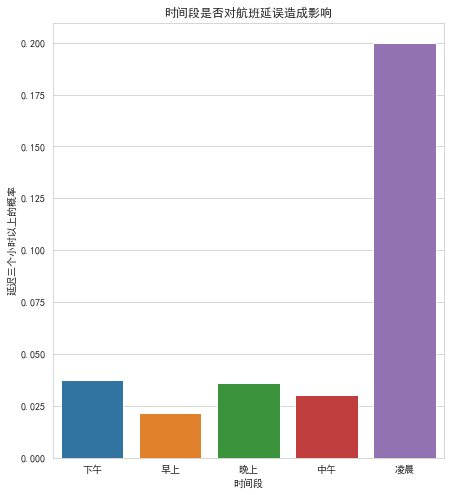

In [44]:
commonNoon = train['时间段'].value_counts().iloc[:20].index
train_group = train.groupby('时间段')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (7, 8)) 
sns.barplot(commonNoon, train_mean_y.loc[commonNoon].values[:,0])
plt.xlabel('时间段')
plt.ylabel('延迟三个小时以上的概率')
plt.title('时间段是否对航班延误造成影响')
plt.show()
fig.savefig('时间段是否对航班延误造成影响.pdf')

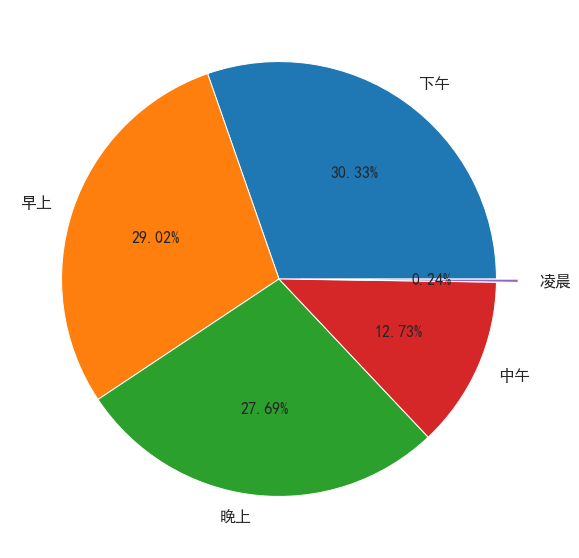

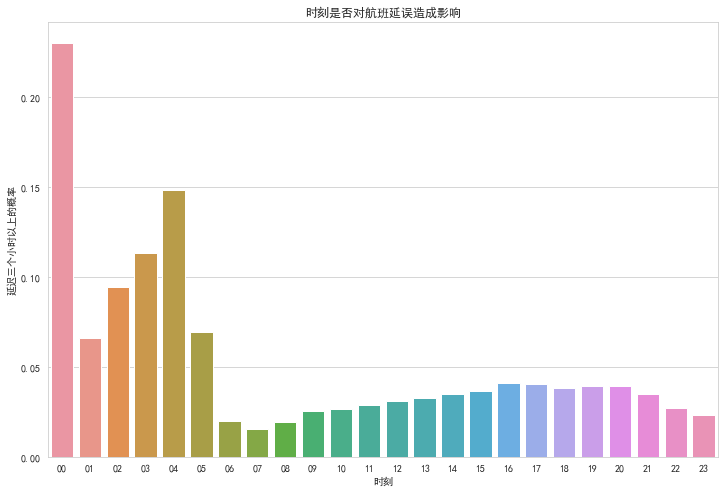

In [45]:
Noon_count =  train['时间段'].value_counts()
fig, ax = plt.subplots(figsize=(10, 10)) 
exp = [0, 0, 0, 0, 0.1]
plt.pie(x=Noon_count.values, labels=Noon_count.index, explode=exp, 
        autopct="%0.2f%%", textprops={'fontsize':16})
plt.show()
fig.savefig('Noon_count.pdf')

commonHour = train['时刻'].value_counts().index
train_group = train.groupby('时刻')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (12, 8)) 
sns.barplot(commonHour, train_mean_y.loc[commonHour].values[:,0])
plt.xlabel('时刻')
plt.ylabel('延迟三个小时以上的概率')
plt.title('时刻是否对航班延误造成影响')
plt.show()
fig.savefig('时刻是否对航班延误造成影响.pdf')

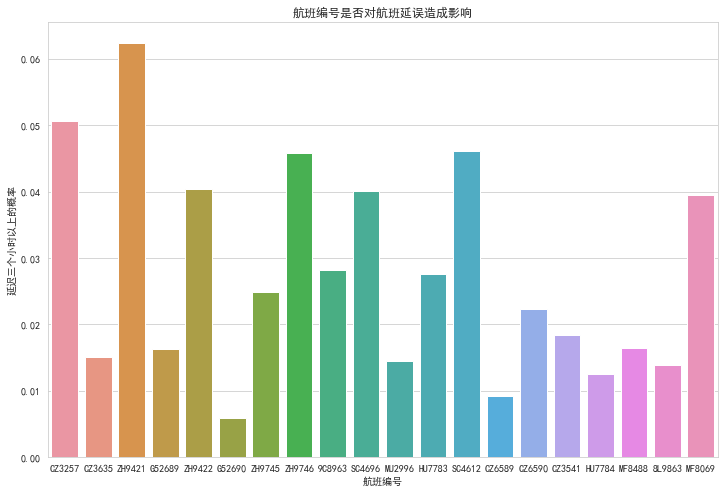

In [46]:
Flight_counts = train['航班编号'].value_counts()
Flight_counts = Flight_counts / Flight_counts.sum()
commonFlight = Flight_counts.iloc[:20].index
train_group = train.groupby('航班编号')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (12, 8)) 
sns.barplot(commonFlight, train_mean_y.loc[commonFlight].values[:,0])
plt.xlabel('航班编号')
plt.ylabel('延迟三个小时以上的概率')
plt.title('航班编号是否对航班延误造成影响')
plt.show()
fig.savefig('航班编号是否对航班延误造成影响.pdf')

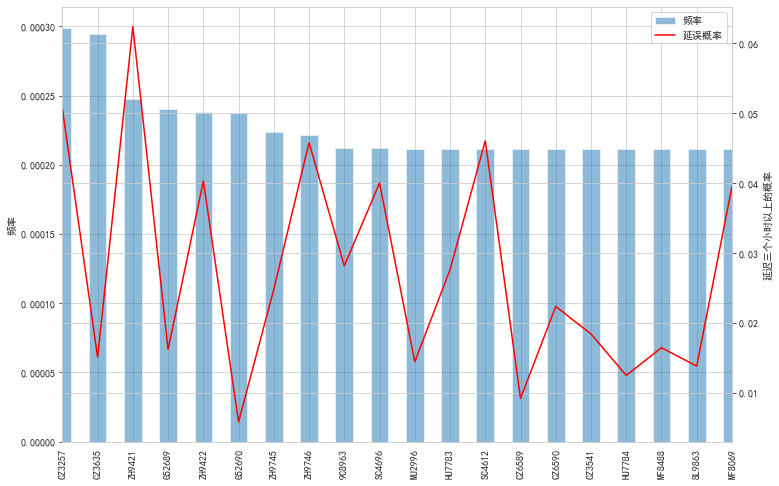

In [47]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
Flight_counts.loc[commonFlight].plot(kind='bar', ax=ax1, alpha=0.5)
train_mean_y.loc[commonFlight].plot(ax=ax2, color='r')
ax1.set_ylabel('频率')
ax2.set_ylabel('延迟三个小时以上的概率')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
labels1 = ['频率']
labels2 = ['延误概率']
plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
plt.show()
fig.savefig('航班编号是否对航班延误造成影响（2）.pdf')

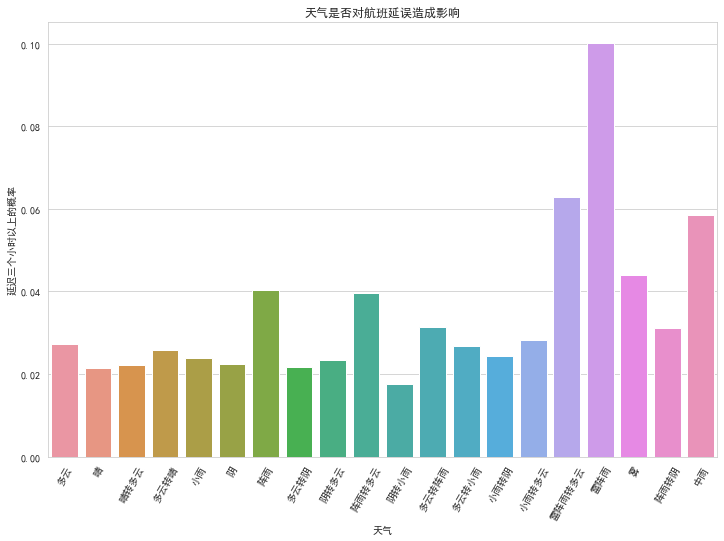

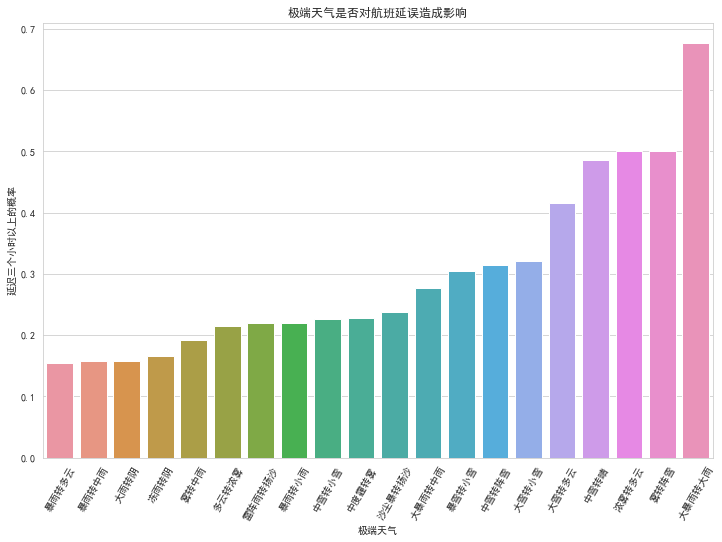

In [48]:
commonWeather = train['天气'].value_counts().iloc[:20].index
train_group = train.groupby('天气')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(commonWeather, train_mean_y.loc[commonWeather].values[:,0])
plt.xlabel('天气')
plt.ylabel('延迟三个小时以上的概率')
plt.xticks(rotation = 60)
plt.title('天气是否对航班延误造成影响')
plt.show()
fig.savefig('天气是否对航班延误造成影响.pdf')

train_group = train.groupby('天气')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)]).rename(columns = {'<lambda>':'延误频率'})
commonWeather = train_mean_y.sort_values(by = '延误频率').index[-20:]

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(commonWeather, train_mean_y.loc[commonWeather].values[:,0])
plt.xlabel('极端天气')
plt.ylabel('延迟三个小时以上的概率')
plt.xticks(rotation = 60)
plt.title('极端天气是否对航班延误造成影响')
plt.show()
fig.savefig('极端天气是否对航班延误造成影响.pdf')

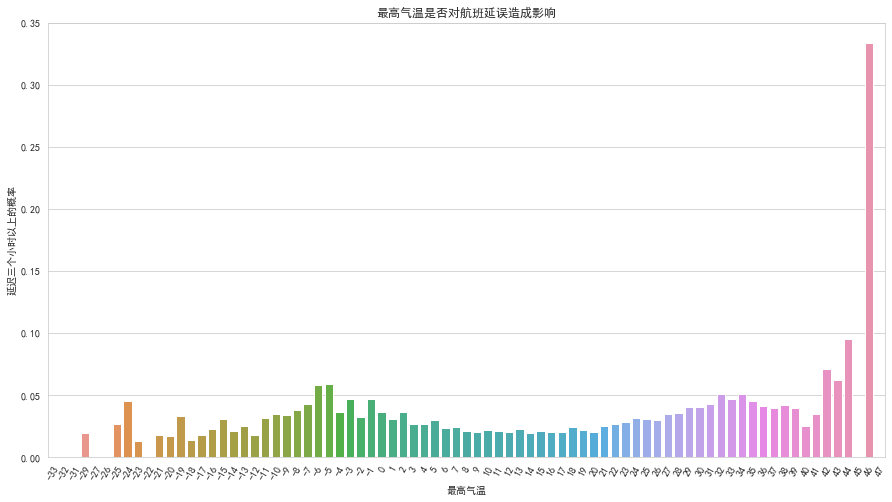

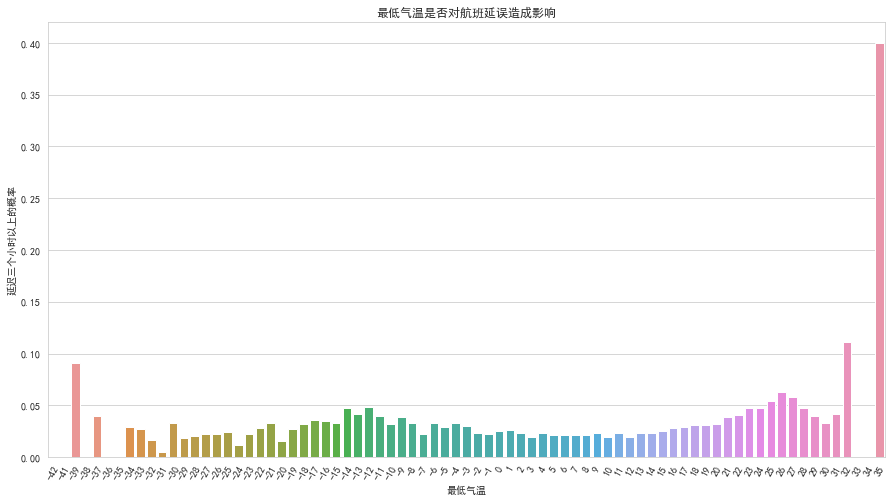

In [49]:
train_group = train.groupby('最高气温')
train_mean_y = train_group['y'].agg([lambda x:np.mean(x)]).rename(columns = {'<lambda>':'延误频率'})

fig, ax = plt.subplots(figsize = (15,8))
sns.barplot([int(it) for it in train_mean_y.index], train_mean_y.values[:,0])
plt.xlabel('最高气温')
plt.ylabel('延迟三个小时以上的概率')
plt.xticks(rotation = 60)
plt.title('最高气温是否对航班延误造成影响')
plt.show()
fig.savefig('最高气温是否对航班延误造成影响.pdf')

train_group = train.groupby('最低气温')
train_mean_y = train_group['y'].agg([lambda x:np.mean(x)]).rename(columns = {'<lambda>':'延误频率'})

fig, ax = plt.subplots(figsize = (15,8))
sns.barplot([int(it) for it in train_mean_y.index], train_mean_y.values[:,0])
plt.xlabel('最低气温')
plt.ylabel('延迟三个小时以上的概率')
plt.xticks(rotation = 60)
plt.title('最低气温是否对航班延误造成影响')
plt.show()
fig.savefig('最低气温是否对航班延误造成影响.pdf')

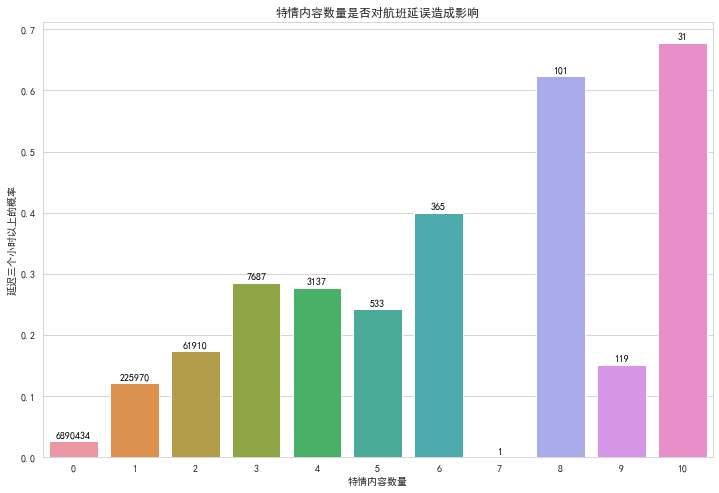

In [50]:
train_group = train.groupby('特情内容数量')
train_mean_y = train_group['y'].agg([lambda x:np.mean(x)]).rename(columns = {'<lambda>':'延误频率'})
commonEmergency = train_mean_y.sort_values(by = '延误频率')

EmergencyCount = train['特情内容数量'].value_counts()
commonEmergency['counts'] = EmergencyCount
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.barplot(commonEmergency.index, commonEmergency['延误频率'])
plt.xlabel('特情内容数量')
plt.ylabel('延迟三个小时以上的概率')

for i in range(len(EmergencyCount)):
	g.text(i, commonEmergency['延误频率'][i] + 0.005, EmergencyCount[i], color = 'black', ha = 'center')

plt.title('特情内容数量是否对航班延误造成影响')
plt.show()
fig.savefig('特情内容数量是否对航班延误造成影响.pdf')

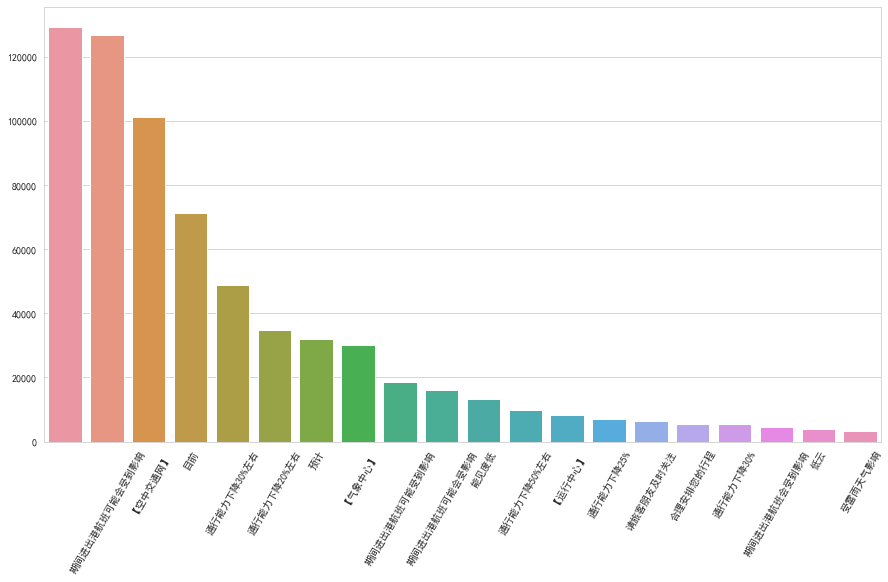

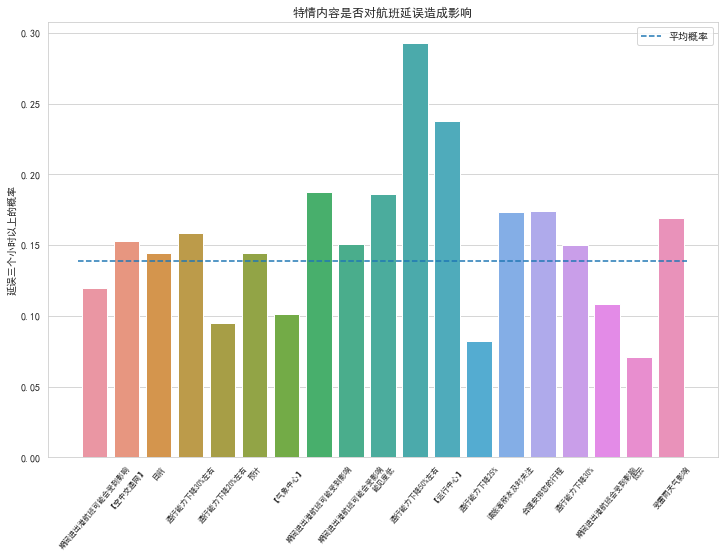

In [51]:
train_emergency = train.loc[pd.notnull(train['特情内容'])]
train_emergency['天气'].value_counts()

def split_str(str_one):
	str_one = str_one.replace('。','，')
	str_one = str_one.replace(',','，')
	str_one = str_one.replace('.','，')
	return str_one.split('，')

split_emergency = [split_str(it) for it in train_emergency['特情内容']]

split_extend = []
for it in split_emergency:
	split_extend.extend(it)

split_counts = pd.Series(split_extend).value_counts()

plt.figure(figsize = (15,8))
sns.barplot(split_counts.index[:20], split_counts.values[:20])
plt.xticks(rotation = 60)
plt.show()
 
interest_index = split_counts.index[1:20]

def get_poss_for_sen(sen):
	sen_bool = [sen in it for it in train_emergency['特情内容']]
	train_emergency_having_sen = train_emergency.loc[sen_bool, :]
	return np.mean(train_emergency_having_sen['y'])

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(interest_index, pd.Series([get_poss_for_sen(it) for it in interest_index]))
plt.xticks(rotation = 50, fontsize = 7.5)
line_bound = np.arange(-0.5, len(interest_index) + 0.5, 1)
plt.plot(line_bound, [np.mean(train_emergency['y']) for i in line_bound], '--', label = '平均概率')
plt.legend()
plt.ylabel('延误三个小时以上的概率')
plt.title('特情内容是否对航班延误造成影响')
plt.show()
fig.savefig('特情内容是否对航班延误造成影响.pdf')

In [53]:
f = open('useful_text.txt', 'r', encoding = 'gbk')
all_str = f.read()
useful_text = all_str.split('\n\n')
useful_text_unique = np.unique(useful_text)

train_emergency_content = train_emergency['特情内容']
content_mean = pd.Series([0] * len(useful_text_unique), index = useful_text_unique)
for i, txt in enumerate(useful_text_unique):
	txt_is_in = [txt in it for it in train_emergency['特情内容']]
	content_mean.iloc[i] = np.mean(train_emergency.loc[txt_is_in, 'y'])

content_mean = content_mean.sort_values()

train['特情紧急程度'] = [0] * len(train)
for i, txt in enumerate(content_mean.index):
	txt_is_in = [txt in it for it in train_emergency['特情内容']]
	txt_in_index = train_emergency.loc[txt_is_in, :].index
	train['特情紧急程度'].loc[txt_in_index] += content_mean[txt]

C:\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


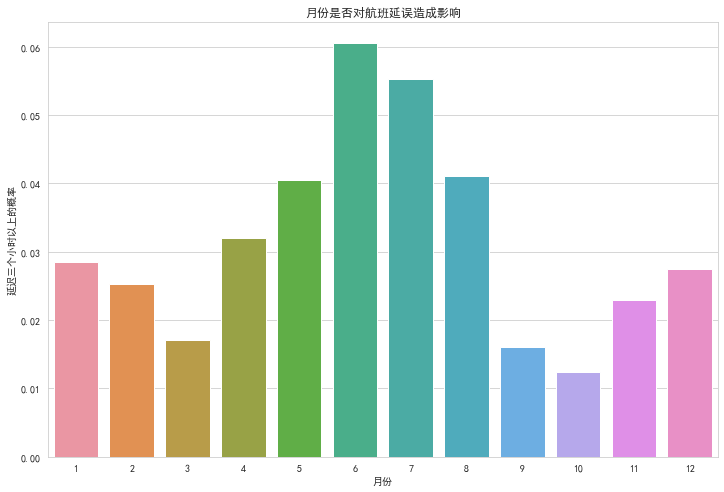

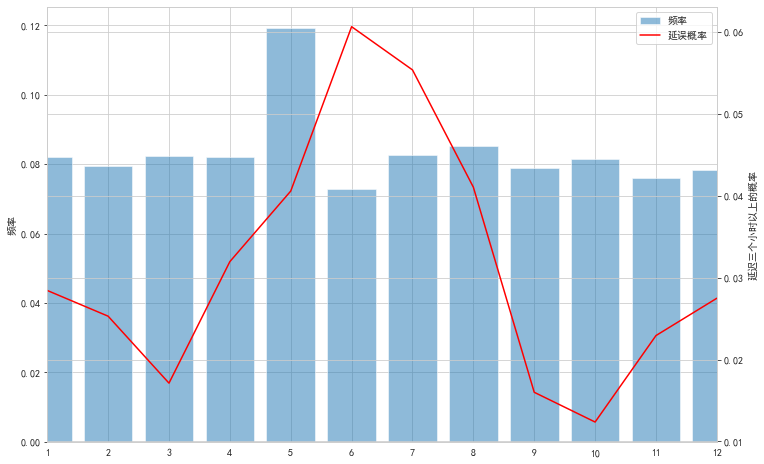

In [56]:
train['时间'] = train['机场_时间_航班编号'].apply(lambda x: datetime.strptime(x[9:28], 
                                                                    '%Y-%m-%d %H:%M:%S'))
train = train.sort_values(by='时间')

train['月份'] = train['时间'].apply(lambda x: x.month)

Month_counts = train['月份'].value_counts()
Month_counts = Month_counts / Month_counts.sum()
commonMonth = train['月份'].value_counts().index
train_group = train.groupby('月份')

train_mean_y = train_group['y'].agg([lambda x:np.mean(x)])

fig, ax = plt.subplots(figsize = (12, 8)) 
sns.barplot(commonMonth, train_mean_y.loc[commonMonth].values[:,0])
plt.xlabel('月份')
plt.ylabel('延迟三个小时以上的概率')
plt.title('月份是否对航班延误造成影响')
plt.show()
fig.savefig('月份是否对航班延误造成影响.pdf')

Month_counts = Month_counts.sort_index()
train_mean_y = train_mean_y.sort_index()

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
ax1.bar(Month_counts.index, Month_counts.values, alpha=0.5, label='频率')
train_mean_y.plot(ax=ax2, color='r')
ax1.set_ylabel('频率')
ax2.set_ylabel('延迟三个小时以上的概率')
plt.xticks(list(range(1, 13)))
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
labels1 = ['频率']
labels2 = ['延误概率']
plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
plt.show()
fig.savefig('月份是否对航班延误造成影响（2）.pdf')

In [59]:
train_last_col = ['时间', '飞机编号', '航空公司', '时间段', '机场', '航班编号', '天气', '特情紧急程度','最高气温', 
                    '最低气温', '特情内容数量', '计划飞行时间', '月份', 'y']

train_last = train.loc[:, train_last_col]
with open('train.pkl', 'wb') as file:
    pickle.dump(train_last, file)